In [1]:
import skgeom as sg
import numpy as np
import pyclipper
from numba import njit, jit, literal_unroll
import math
from pydantic import BaseModel
import random
import itertools
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection, LinearRing, MultiLineString, LineString, Point
import matplotlib.pyplot as plt
import sys
%load_ext line_profiler
import time
import copy

In [33]:
# example polygons
# polygons are defined as tuple(tuple(float, float)) because we use them as `dict` keys

pg0 = (
    (0, 0),
    (8, 0),
    (8, 9),
    (9, 9),
    (9, 3),
    (1, 3),
    (1, 9),
    (0, 9),
)

pg1 = (  # this is a square with a notch on the top
    (0, 0),
    (10, 0),
    (10, 10),
    (7, 10),
    (7, 5),
    (3, 5),
    (3, 10),
    (0, 10)
)

pg2 = (  # this is a triangle with
    (0, 0),
    (10, 0),
    (5, math.tan(math.pi / 3) * 5)
)

pg3 = (  # this is a parallelogram leaning on the right
    (0, 0),
    (5, 0),
    (10, 10),
    (5, 10)
)

pg4 = (  # звездочка
    (0, 3),
    (2, 4),
    (3, 6),
    (4, 4),
    (6, 3),
    (4, 2),
    (3, 0),
    (2, 2)
)

# pg4 = ( 
#     (0, 2),
#     (1.5, 2.5),
#     (2, 4),
#     (2.5, 2.5),
#     (4, 2),
#     (2.5, 1.5),
#     (2, 0),
#     (1.5, 1.5)
# )

pg5 = (  # this is a square
    (0, 0),
    (10, 0),
    (10, 10),
    (0, 10)
)

pg6 = (  # this is a trapeze
    (0, 0),
    (9, 0),
    (6, 5),
    (3, 5)
)

pg7 = (  # восьмиугольник
    (0, 4),
    (0, 8),
    (4, 12),
    (8, 12),
    (12, 8),
    (12, 4),
    (8, 0),
    (4, 0)
)

pg8 = (  # треугольник прямоугольный
    (0, 0),
    (10, 0),
    (0, 10)
)

# pg5 = (
#     (0, 0),
#     (9, 0),
#     (5, 40)
# )

#bin_size = (55, 100)  # size of the container
bin_size = (70, 100)

# Packing

Following functions are base functions to make a packing + some utilities to display results. It doesn't include optimisation of the nesting order or polygon orientation yet.

Data structure is kept as basic as possible (so using built-in python types + numpy arrays) for two reasons:
- basic types often offers better performance
- the algorithm structure is not yet frozen, so I avoided adding abstractions as much as possible

In [64]:
class Packing:
    """Class representing a packing (aka a nesting), that is a list of containers (aka bins) containing polygons with a certain position (aka translation)"""
    
    def __init__(self, bin_size, polygons, bins=None):
        self.bin_size = bin_size  # bins are all the same size, defined by `bin_size` 
        self.polygons = tuple(polygons.keys())  # polygons we want to fit inside bins (this contains only unique occurences of polygons)
        
        # bins are initially empty except if specified in argument `bins`
        # each bin is a list of tuples, each tuple in a bin contains the following: 
        # (initial polygon: tuple(tuple(float, float)), transformed polygon: tuple(tuple(float, float)), translation to locate transformed polygon in the bin: np.array)
        if bins is None:
            self.bins = []
        else:
            self.bins = [[(x, y, np.array(z)) for x, y, z in abin] for abin in bins]
        
        # each polygon `pg` will be nested `n` times, `n` being the integer in `quantities` at the same index as `pg` is in polygons
        # if bins are specified, already nested polygons are excluded from the total `quantities`. This finally gives remaining quantities to nest
        
        # fitness-fuction weights
        self.coeffs = (1/2, 1/2, 0)
        
#         self.bin = []
#         self.invalid = []
#         self.remaining = {pg: qty - len([True for  x, _, _ in self.bin if x == pg]) 
#                           for pg, qty in zip(self.polygons, quantities)}

        self.remaining = {pg: qty - len([True for abin in self.bins for  x, _, _ in abin if x == pg]) 
                          for pg, qty in polygons.items()}
        
    def nest_all(self, mode, rand, init, rate):
        """Will nest all polygons not yet nested according to remaining quantities"""
        if mode == 'fast greedy':
            self.make_initial_nesting(1, rand)
        elif mode == 'full greedy':
            self.make_initial_nesting(0, rand)
        elif mode == 'simulated annealing':
            self.make_initial_nesting(1, rand)
            self.simulated_annealing(init, rate)
            # не проработан вариант с наличием трансформаций
            # не проработан вариант с тем, что фигуры на последнем листе кончатся (и его нужно будет удалить)
        elif mode == 'genetic':
            self.make_initial_nesting(1, rand)
    
#     def make_initial_nesting(self, fast=True):
#         """Will nest all polygons not yet nested according to remaining quantities"""
#         for polygon in self.polygons:
#             for _ in range(self.remaining[polygon]):
#                 self.initial_polygon_nest(polygon, fast=fast)
                
    def make_initial_nesting(self, fast=True, rand=False):
        """Will nest all polygons not yet nested according to remaining quantities"""
        if rand:
            while self.remaining:
                polygon = random.choice(self.polygons)
                self.initial_polygon_nest(polygon, rand, fast=fast)
        else:
            for polygon in self.polygons:
                for _ in range(self.remaining[polygon]):
                    self.initial_polygon_nest(polygon, rand, fast=fast)
                
    def initial_polygon_nest(self, polygon, rand, flip=False, rotation=0, fast=False):
        """Will nest the input polygon if the initial quantity for this polygon hasn't been reached yet"""
        if not self.remaining.get(polygon):
            return False
        
        # apply transformation
        if fast:
            transformed_polygon = apply_transformations(polygon, flip, rotation)
        else:
            transformed_polygons = [apply_transformations(polygon, flip, rotation) for flip in (False, True) for rotation in (0, 90, 180, 270)]
        # transformed_polygons = [apply_transformations(polygon, flip, rotation) for flip in (True,) for rotation in (0, 90, 180, 270)]

        bin_offset = -1 if fast else 0  # try only last bin if `fast` is True (avoid exponential complexity)
#         for abin in self.bins[bin_offset:]:    
#             valid_pts = find_nfp(abin, self.bin_size, transformed_polygon)
#             if len(valid_pts):
#                 abin.append((polygon, transformed_polygon, select_best_nfp_pt(valid_pts)))
#                 break

        if not fast:
            flag = []
            bbins = []
            for abinidx in range(len(self.bins)):
                valid_pts_list = []
                transformed_polygons_ = copy.deepcopy(transformed_polygons)
                for i in range(len(transformed_polygons)):
                    # print('qqq', self.bins[abinidx])
                    # print('www', transformed_polygons)
                    nfp = find_nfp(self.bins[abinidx], self.bin_size, transformed_polygons[i])
                    if len(nfp):
                        valid_pts_list.append(nfp)
                    else:
                        transformed_polygons_[i] = -1
                if len(valid_pts_list):
                    transformed_polygons_ = [x for x in transformed_polygons_ if x != -1]
                    bins = [copy.deepcopy(self.bins) for _ in range(len(valid_pts_list))]
                    fit = []
                    for j in range(len(valid_pts_list)):
                        bins[j][abinidx].append((polygon, transformed_polygons_[j], select_best_nfp_pt(valid_pts_list[j])))
                        fit.append(fitness(bins[j], self.bin_size, self.coeffs))
                    idx = np.argmax(fit)
                    bbins.append(bins[idx])
                else:
                    flag.append(1)
            # print('len(flag) =', len(flag))
            # print('len(self.bins) =', len(self.bins))
            if len(flag) == len(self.bins):  # if else statement is executed, it means that the polygon did not fit in any existing bins, we need to add a new bin
                # TODO: check if polygon fits alone in a new bin
                self.bins.append([(polygon, polygon, np.zeros(2))])
            else:
                maxi = -1
                bestbins = []
                for bins in bbins:
                    fit = fitness(bins, self.bin_size, self.coeffs)
                    if fit > maxi:
                        maxi = fit
                        bestbins = bins
                self.bins = bestbins
        else:
            for abin in self.bins[bin_offset:]:    
                valid_pts = find_nfp(abin, self.bin_size, transformed_polygon)
                if len(valid_pts):
                    abin.append((polygon, transformed_polygon, select_best_nfp_pt(valid_pts)))
                    break
            else:  # if else statement is executed, it means that the polygon did not fit in any existing bins, we need to add a new bin
                # TODO: check if polygon fits alone in a new bin
                self.bins.append([(polygon, transformed_polygon, np.zeros(2))])
#         if self.bin:
#             valid_pts = find_nfp(self.bin, self.bin_size, transformed_polygon)
#             if len(valid_pts):
#                 self.bin.append((polygon, transformed_polygon, select_best_nfp_pt(valid_pts)))

#             else:  # if else statement is executed, it means that the polygon did not fit in any existing bins, we need to add a new bin
#                 # TODO: check if polygon fits alone in a new bin
#                 #self.bins.append([(polygon, transformed_polygon, np.zeros(2))])
#                 self.invalid.append((polygon, transformed_polygon, np.zeros(2)))
#         else:
#             self.bin.append((polygon, transformed_polygon, np.zeros(2)))

        self.remaining[polygon] -= 1
        if rand and (not self.remaining[polygon]):
            self.remaining.pop(polygon)
        return True
    
    def nest_polygon_to_a_bin(self, polygon, abin):
        """Will nest the input polygon if the initial quantity for this polygon hasn't been reached yet"""        
        # apply transformation
        # print('1', polygon)
        flip = np.random.choice([True, False])
        rotation = np.random.choice([0, 90, 180, 270])
        # print(polygon)
        transformed_polygon = apply_transformations(polygon[1], flip, rotation)
        # print('2', transformed_polygon)
        valid_pts = find_nfp(abin, self.bin_size, transformed_polygon)
        if len(valid_pts):
            polygon = (polygon[0], transformed_polygon, select_best_nfp_pt(valid_pts))
            abin.append(polygon)
            return True
        else:
            return False
    
#     def make_a_move(self):
#         polygon = self.bins[-1][-1]
#         for idx in range(len(self.bins[:-1])):
#             # print('idx', idx)
#             if self.nest_polygon_to_a_bin(polygon, self.bins[idx]):
#                 return idx
#         else:
#             return -1
        
    def make_a_swap_move(self):
        bins = copy.deepcopy(self.bins)
        binidx1 = np.random.randint(0, len(bins))
        binidx2 = np.random.randint(0, len(bins))
        polyidx1 = np.random.randint(0, len(bins[binidx1]))
        polyidx2 = np.random.randint(0, len(bins[binidx2]))
        if self.nest_polygon_to_a_bin(bins[binidx1][polyidx1], bins[binidx2]) and self.nest_polygon_to_a_bin(bins[binidx2][polyidx2], bins[binidx1]):
            bins[binidx1].pop(polyidx1)
            bins[binidx2].pop(polyidx2)
            return bins
        else:
            return "error"
            
    
    def simulated_annealing(self, init_temp, temp_decr_rate):
        temperature = init_temp
        energy = fitness(self.bins, self.bin_size, self.coeffs)
        while temperature > 0:
            bins = self.make_a_swap_move()
            # print('returned idx', idx)
            if bins != 'error':
                energy_diff = fitness(bins, self.bin_size, self.coeffs) - energy
            if bins != 'error' and (energy_diff >= 0 or np.random.random() >= np.exp(energy_diff / temperature)):
                self.bins = bins
                temperature -= temp_decr_rate
            else:
                temperature -= temp_decr_rate * 0.1
    
#     def fitness(self):
#         """Packing fitness"""
#         fitness_A = (sum(self.bin_fitness_A(abin) for abin in self.bins[:-1]) + self.last_bin_fitness_A(self.bins[-1]))  / len(self.bins)
#         fitness_B = sum(self.bin_fitness_B(abin) for abin in self.bins) / len(self.bins)
#         #fitness_C = ((self.bin_size[0] * self.bin_size[1]) - max(self.bin_fitness_C(abin) for abin in self.bins)) / (self.bin_size[0] * self.bin_size[1]) 
#         fitness_C = 0
#         return 1 - self.A * fitness_A + self.B * fitness_B + self.C * fitness_C
    
#     def bin_fitness_A(self, abin):
#         """Packing fitness part a, lower is better"""
#         polygons = [Polygon(pg + translation) for _, pg, translation in abin]
#         union = GeometryCollection(polygons)
#         return 1 - sum(pg.area for pg in polygons) / (self.bin_size[0] * self.bin_size[1])
    
#     def last_bin_fitness_A(self, abin):
#         """Packing fitness part a, lower is better"""
#         polygons = [Polygon(pg + translation) for _, pg, translation in abin]
#         union = GeometryCollection(polygons)
#         return 1 - sum(pg.area for pg in polygons) / union.envelope.area
    
#     def bin_fitness_B(self, abin):
#         """Packing fitness part b, lower is better
#         It computes an "emptyness" ratio between the sum of each polygons area and the total area of the convex hull of all polygons
#         So if packing is good, polygons fill most of the convex hull and the fitness is low. 
#         This fitness is calculated by bins and then averaged.
#         """
#         polygons = [Polygon(pg + translation) for _, pg, translation in abin]
#         union = GeometryCollection(polygons)
#         return 1 - sum(pg.area for pg in polygons) / union.convex_hull.area
#         # ПУНКТ Б ПОСТАНОВКИ ЗАДАЧИ (МАКСИМАЛЬНО ПЛОТНОЕ РАЗМЕЩЕНИЕ): НУЖНО ОПРЕДЕЛИТЬСЯ,
#         # convex_hull, envelope ИЛИ minimum_rotated_rectangle
        
#     def bin_fitness_C(self, abin):
#         """Packing fitness part c, higher is better"""
#         polygons = [Polygon(pg + translation) for _, pg, translation in abin]
#         union = GeometryCollection(polygons)
#         _, _, maxx, maxy = union.envelope.bounds
#         vertical = self.bin_size[1] - maxy
# #         horizontal = self.bin_size[0] - maxx
# #         v_to_h_ratio = vertical / self.bin_size[0]
# #         binmax, binmin = max(self.bin_size), min(self.bin_size)
# #         if v_to_h_ratio < 1:
# #             remmax, remmin = self.bin_size[0], vertical
# #         else:
# #             remmin, remmax = self.bin_size[0], vertical
# #         maxratio = binmax / remmax
# #         minratio = binmin / remmin
#         return vertical * bin_size[0]
    
    def available_polygons(self):
        """returns polygons whose remaining quantities are not 0"""
        return [k for k,v in self.remaining.items() if v > 0]
    
    def hashable_bins(self):
        """returns current bins as nested tuples, so they are hashable and can be used in `dict` as keys"""
        return tuple([tuple([(x, y, tuple(z)) for x, y, z in abin]) 
                      for abin in self.bins])
    
    def get_n_last(self, n_last):
        """return n last polygons (ignoring bins)"""
        all_polygons = [(x, y, tuple(z)) for abin in self.bins for x, y, z in abin]
        return tuple(all_polygons[-n_last:])
    

    
### computation utilities

def fitness(bins, binsize, coeffs):
        """Packing fitness"""
        fitness_A = (sum(bin_fitness_A(abin, binsize) for abin in bins[:-1]) + last_bin_fitness_A(bins[-1]))  / len(bins)
        # fitness_A = len(bins)
        fitness_B = sum(bin_fitness_B(abin) for abin in bins) / len(bins)
        #fitness_C = ((bin_size[0] * bin_size[1]) - max(self.bin_fitness_C(abin, binsize) for abin in self.bins)) / (bin_size[0] * bin_size[1]) 
        fitness_C = 0
        A, B, C = coeffs
        return 1 - (A * fitness_A + B * fitness_B + C * fitness_C)
    
def bin_fitness_A(abin, bin_size):
    """Packing fitness part a, lower is better"""
    polygons = [Polygon(pg + translation) for _, pg, translation in abin]
    union = GeometryCollection(polygons)
    return 1 - sum(pg.area for pg in polygons) / (bin_size[0] * bin_size[1])

def last_bin_fitness_A(abin):
    """Packing fitness part a, lower is better"""
    polygons = [Polygon(pg + translation) for _, pg, translation in abin]
    union = GeometryCollection(polygons)
    return 1 - sum(pg.area for pg in polygons) / union.envelope.area

def bin_fitness_B(abin):
    """Packing fitness part b, lower is better
    It computes an "emptyness" ratio between the sum of each polygons area and the total area of the convex hull of all polygons
    So if packing is good, polygons fill most of the convex hull and the fitness is low. 
    This fitness is calculated by bins and then averaged.
    """
    polygons = [Polygon(pg + translation) for _, pg, translation in abin]
    union = GeometryCollection(polygons)
    return 1 - sum(pg.area for pg in polygons) / union.convex_hull.area
    # ПУНКТ Б ПОСТАНОВКИ ЗАДАЧИ (МАКСИМАЛЬНО ПЛОТНОЕ РАЗМЕЩЕНИЕ): НУЖНО ОПРЕДЕЛИТЬСЯ,
    # convex_hull, envelope ИЛИ minimum_rotated_rectangle

def bin_fitness_C(abin, bin_size):
    """Packing fitness part c, higher is better"""
    polygons = [Polygon(pg + translation) for _, pg, translation in abin]
    union = GeometryCollection(polygons)
    _, _, maxx, maxy = union.envelope.bounds
    vertical = bin_size[1] - maxy
#         horizontal = self.bin_size[0] - maxx
#         v_to_h_ratio = vertical / self.bin_size[0]
#         binmax, binmin = max(self.bin_size), min(self.bin_size)
#         if v_to_h_ratio < 1:
#             remmax, remmin = self.bin_size[0], vertical
#         else:
#             remmin, remmax = self.bin_size[0], vertical
#         maxratio = binmax / remmax
#         minratio = binmin / remmin
    return vertical * bin_size[0]

def apply_transformations(polygon, flip=False, rotation=0):
    """apply transformations to the input polygon and returns the transformed polygon"""
    global TRANSFORMATIONS  # use as cache
    cached_result = TRANSFORMATIONS.get((polygon, flip, rotation))
    if cached_result is not None:
        # if cache not available, apply transformations
        return cached_result
    
    if flip:  # flip = mirror effect, along y in this case
        polygon = tuple([(x, -y) for x, y in polygon]) 
        
    if rotation:
        radian = rotation * math.pi / 180
        polygon = tuple([(epsilon(x * math.cos(radian) - y * math.sin(radian)), epsilon(y * math.cos(radian) + x * math.sin(radian))) for x, y in polygon]) 
       
    # polygon is shifted to the origin by default (important!)
    shift = np.min(polygon, axis=0)
    polygon = tuple([(epsilon(x - shift[0]), epsilon(y - shift[1])) for x, y in polygon]) 
    
    TRANSFORMATIONS[(polygon, flip, rotation)] = polygon
    return polygon

def roundup(flnum):
    if flnum == int(flnum):
        return int(flnum)
    else:
        return int(flnum) + 1
    
def epsilon(number):
    if roundup(number) > number and roundup(number) - number < EPS:
        return roundup(number)
    elif  number > int(number) and number - int(number) < EPS:
        return int(number)
    else:
        return number

def select_best_nfp_pt(pts):
    """Return one point among all input points `pts`.
    Input points `pts` are the valid positions to  fit a new polygon in an existing container with other polygons
    It selects the point which minimizes the vertical position (so polygon are stacked at the bottom of the container)
    """
    pts = np.array(pts)
    ix = np.argmin(pts[:, 1])
    return pts[ix]


def find_nfp(abin, bin_size, polygon):
    """Given an existing container (defined by `abin` and `bin_size`), returns all the valid positions to fit the new `polygon` into this container"""

    # list of minkowski sums between existing polygon and the new polygon, translated by the respective positions of existing polygon
    paths = [get_minkowski_sum(polygon_, polygon, translation) 
             for _, polygon_, translation in abin]
    
    # make a union of all minkowski sums, cf clipper library http://www.angusj.com/delphi/clipper.php
    pc = pyclipper.Pyclipper()
    pc.AddPaths(paths, pyclipper.PT_SUBJECT, True)
    nfps = pc.Execute(pyclipper.CT_UNION, pyclipper.PFT_POSITIVE, pyclipper.PFT_POSITIVE)
    # nfp means non-fitting polygon, with an 's' because it can be composed of several separated polygons
    # all points belonging to the nfps (so a vertice or on any edge) are valid positions to place the new polygon
    
    valid_pts = []
    for nfp in nfps:
        # so far, container edges were not taken into account to compute the nfp
        # the next step clips the nfp in order to keep only the part which fits inside the container
        bin_pts = get_clipping_limits(bin_size, polygon)
        pc = pyclipper.Pyclipper()
        pc.AddPath(bin_pts, pyclipper.PT_CLIP, True)
        pc.AddPaths([nfp], pyclipper.PT_SUBJECT, True)
        nfp_clip = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_NONZERO, pyclipper.PFT_NONZERO)

        # the previous step creates new points, like intersection of nfp edges with container edges
        # some of these points are not valid position, we compare the original nfp and the clipped nfp the remove keep only valid points
        nfp_flat = np.array(nfp)
#         print(nfp_flat)
#         print('/////////////////////')
#         print(nfp_clip)
        if nfp_clip:
            nfp_clip_flat = np.array(nfp_clip[0])
        else:
            continue
#         print('/////////////////////')
#         print(nfp_clip_flat)
#         print('#####################')
        valid_pts.append(get_valid_pts(nfp_flat, nfp_clip_flat))
    return np.concatenate(valid_pts) if valid_pts else np.array([])  # finally we return all the valid positions to fit the new polygon into the existing container

def get_minkowski_sum(pg1: tuple, pg2: tuple, translation):
    """Minkowski sum is an operation between two polygons. 
    It returns a single polygon (often named nfp for non-fitting polygon) which corresponds to the union of all positions of pg1 and pg2 so that they touch each other without overlapping.
    cf https://camo.githubusercontent.com/6ff0febec651b9e82b37226d6a8f6f75d0e4232cb7fb90cc65c3c85d762b8a49/687474703a2f2f7376676e6573742e636f6d2f6769746875622f6e66702e706e67
    This function also applies a translation to the resulting polygon.
    
    Note: this function is more specifically a minkowski difference as pg2 is reversed in the code, however minkowski sum is a more usual term
    Note: `pg1` and `pg2` should be tuples of points, with first point and last point not equal (ie: no need to close the polygon by repeating first point to last position)
    """
    global SINGLE_NFPS  # used as cache
    
    minkowski_sum = SINGLE_NFPS.get(hash((pg1, pg2)))
    if minkowski_sum is None:
        # if cache not available, compute minkowski sum
        skpg1 = sg.Polygon(pg1)
        if skpg1.orientation() == -1:  # check that polygon has the right orientation
            skpg1.reverse_orientation()

        skpg2 = sg.Polygon(-1 * np.array(pg2))
        if skpg2.orientation() == -1:
            skpg2.reverse_orientation()

        # cf library scikit-geom https://scikit-geometry.github.io/scikit-geometry/polygon.html#Minkowski-Sum-of-2-Polygons
        minkowski_sum = sg.minkowski.minkowski_sum(skpg1, skpg2).outer_boundary().coords
        SINGLE_NFPS[hash((pg1, pg2))] = minkowski_sum
    return vec_sum(minkowski_sum, translation)

@njit()
def vec_sum(array1, array2):
    """Sum of vectors, accelerated with numba"""
    return array1 + array2

@njit(cache=True)
def get_clipping_limits(bin_size, polygon):
    """Returns a rectangle corresponding to the container but offseted (toward the inside) with polygon delta along x and y 
    Geometrically, this rectangle corresponds to the most extreme positions of the polygon when moving the polygon along the edge of the container without intersecting it
    """
    array = np.array(polygon)
    x = np.max(array[:, 0]) - np.min(array[:, 0])
    y = np.max(array[:, 1]) - np.min(array[:, 1])
    return np.array([
        [0.0, 0.0],
        [float(bin_size[0] - x), 0.0],
        [float(bin_size[0] - x), float(bin_size[1] - y)],
        [0.0, float(bin_size[1] - y)]
    ])

@njit()
def get_valid_pts(pg, pg_to_test):
    """Given two arrays `pg` and `pg_to_test` describing polygons, returns all vertices of `pg_to_test` which are intersecting with `pg`
    The main idea of this function is to use cross and dot products between vectors to understand which points of `pg_to_test` also belong to an edge or a vertice of `pg`
    This function is Numba compatible
    """
    pg_ = np.vstack((pg[-1:], pg[:-1]))
    vectors = pg_ - pg  # defines `pg` as a array of vectors instead of an array of points
    
    # numpy `np.tile` function is not compatible with numba, but this next step is an equivalent, cf non numba version below
    vectors_tiled = vectors
    for _ in range(len(pg_to_test) - 1):  
        vectors_tiled = np.vstack((vectors_tiled, vectors))
    vectors_tiled = vectors_tiled.reshape(len(pg_to_test), len(pg), 2)
    
#     # NON numba version
#     vectors_tiled = np.tile(vectors, (len(pg_to_test), 1, 1))


    # same here, numba doesn't allow `axis` argument in `np.repeat` function
    pg_to_test_repeated = pg_to_test
    for _ in range(len(pg) - 1):
        pg_to_test_repeated = np.hstack((pg_to_test_repeated, pg_to_test))
        
    pg_tiled = pg
    for _ in range(len(pg_to_test) - 1):
        pg_tiled = np.vstack((pg_tiled, pg))
        
    # `vectors_to_test` represents all possible vectors created with a vertice of `pg` and a vertice of `pg_to_test`
    vectors_to_test = (pg_to_test_repeated.reshape(-1, 2) - pg_tiled).reshape(vectors_tiled.shape)
    
#     # non numba version
#     vectors_to_test = (
#         np.repeat(pg_to_test, len(pg), axis=0) - np.tile(pg, (len(pg_to_test), 1))
#     ).reshape(vectors_tiled.shape)
    
    # `vectors_tiled` represented `pg` as vectors, repeated n times, n being the length of `pg_to_test`
    # using cross product and dot product, we can now understand which points from `pg_to_test` also belongs to `pg`
    cross_product = vectors_tiled[:,:,0] * vectors_to_test[:,:,1] - vectors_tiled[:,:,1] * vectors_to_test[:,:,0]
    dot_product = vectors_tiled[:,:,0] * vectors_to_test[:,:,0] + vectors_tiled[:,:,1] * vectors_to_test[:,:,1]
    valid_pts = pg_to_test[np_any_axis1((cross_product == 0) & (dot_product > 0) & (dot_product <= np.sum(vectors ** 2, axis=1)))]
    return valid_pts

@njit()
def np_any_axis1(x):
    """Numba compatible version of np.any(x, axis=1)."""
    out = np.zeros(x.shape[0], dtype=np.bool8)
    for i in range(x.shape[1]):
        out = np.logical_or(out, x[:, i])
    return out


### Plot Utilities

# def plot_bin(abin, bin_size, fig, ax=None):
#     """Utility function to plot one bin"""
#     if ax is None:
#         ax = fig.add_subplot(aspect='equal')
        
#     for _, pg, translation in abin:
#         translated_pg = pg + translation
#         closed_pg = np.append(translated_pg, translated_pg[[0]], axis=0)
#         ax.fill(closed_pg[:, 0], closed_pg[:, 1])
#     bin_rectangle = get_clipping_limits(bin_size, ((0, 0), ))
#     closed_bin_rectangle = np.append(bin_rectangle, bin_rectangle[[0]], axis=0)
#     ax.plot(closed_bin_rectangle[:, 0], closed_bin_rectangle[:, 1])
    
#     if ax is None:
#         plt.show()
    
# def plot_packing(packing: Packing, size=0.1):
#     """Utility function to plot a packing (see class Packing) made of one or several bins"""
# #     nrows = len(packing.bins) // 4 + 1
# #     ncols = min(4, len(packing.bins))
# #     fig = plt.figure(figsize=(size * ncols, 2 * size * nrows))
# #     gs = fig.add_gridspec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.1)

# #     for i, abin in enumerate(packing.bins):
# #         ax = fig.add_subplot(gs[i // 4, i % 4], aspect='equal')
# #         ax.axis('off')
# #         plot_bin(abin, packing.bin_size, ax)

# #     plt.close()

#     fig = plt.figure(figsize=(size * packing.bin_size[0], size * packing.bin_size[1]))
#     plot_bin(packing.bin, packing.bin_size, fig)
#     plt.close()
    
#     return fig

def plot_bin(abin, bin_size, ax=None):
    """Utility function to plot one bin"""
    if ax is None:
        plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(aspect='equal')
        
    for _, pg, translation in abin:
        translated_pg = pg + translation
        closed_pg = np.append(translated_pg, translated_pg[[0]], axis=0)
        ax.fill(closed_pg[:, 0], closed_pg[:, 1])
    bin_rectangle = get_clipping_limits(bin_size, ((0, 0), ))
    closed_bin_rectangle = np.append(bin_rectangle, bin_rectangle[[0]], axis=0)
    ax.plot(closed_bin_rectangle[:, 0], closed_bin_rectangle[:, 1])
    
    if ax is None:
        plt.show()
    
def plot_packing(packing: Packing, size=3):
    """Utility function to plot a packing (see class Packing) made of one or several bins"""
    nrows = len(packing.bins) // 4 + 1
    ncols = min(4, len(packing.bins))
    fig = plt.figure(figsize=(size * ncols, 2 * size * nrows))
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.1)

    for i, abin in enumerate(packing.bins):
        ax = fig.add_subplot(gs[i // 4, i % 4], aspect='equal')
        ax.axis('off')
        plot_bin(abin, packing.bin_size, ax)

    plt.close()
    return fig

In [29]:
# main speed bottlenecks are visible in this profiling, function `get_minkowski_sum`, `pc.AddPaths` and `get_clipping_limits`
# IMPORTANT first run is slow as numba compiles functions, always run TWICE

SINGLE_NFPS = {}  # do not forget to reset cache before any nesting !
TRANSFORMATIONS = {}
EPS = 0.000001

# polygons = (pg1, pg2, pg3)
polygons = {pg1: 100, pg2: 100, pg3: 100, pg4: 150, pg5: 70, pg6: 30}
# polygons = {pg0:100, pg1: 100, pg2: 100, pg3: 100, pg4: 150, pg5: 70, pg6: 30}
# polygons = {pg1: 100, pg2: 100, pg3: 100, pg4: 150}
polygons = dict(sorted(polygons.items(), key=lambda pg: Polygon(pg[0]).area, reverse=True))
# print(polygons)
# quantities = (1000, 1000, 1000, 1500)
# quantities = (100, 100, 100)
packing = Packing(bin_size, polygons)
# %lprun -f find_nfp packing.nest_all(100)
time1 = time.time()
packing.nest_all('simulated annealing', False, 500, 1)
# packing.nest_all('full greedy', False, 0, 0)
# packing.nest_all('fast greedy', False, 0, 0)
print(time.time() - time1)

120.99318075180054


In [146]:
SINGLE_NFPS = {}
TRANSFORMATIONS = {}
EPS = 0.000001
polygons1 = {pg2: 50, pg3: 50, pg4: 50, pg6: 50, pg7: 50, pg8: 50}
polygons2 = {pg2: 100, pg3: 100, pg4: 100, pg6: 100, pg7: 100, pg8: 100}
polygons3 = {pg2: 150, pg3: 150, pg4: 150, pg6: 150, pg7: 150, pg8: 150}
polygons4 = {pg2: 200, pg3: 200, pg4: 200, pg6: 200, pg7: 200, pg8: 200}
#polygons = dict(sorted(polygons1.items(), key=lambda pg: Polygon(pg[0]).area, reverse=True))
packing = Packing(bin_size, polygons1)
time1 = time.time()
packing.nest_all('simulated annealing', True, 10000, 1)
# packing.nest_all('full greedy', True, 0, 0)
# packing.nest_all('fast greedy', True, 0, 0)
time_ = time.time() - time1
print(time_)

1127.6182260513306


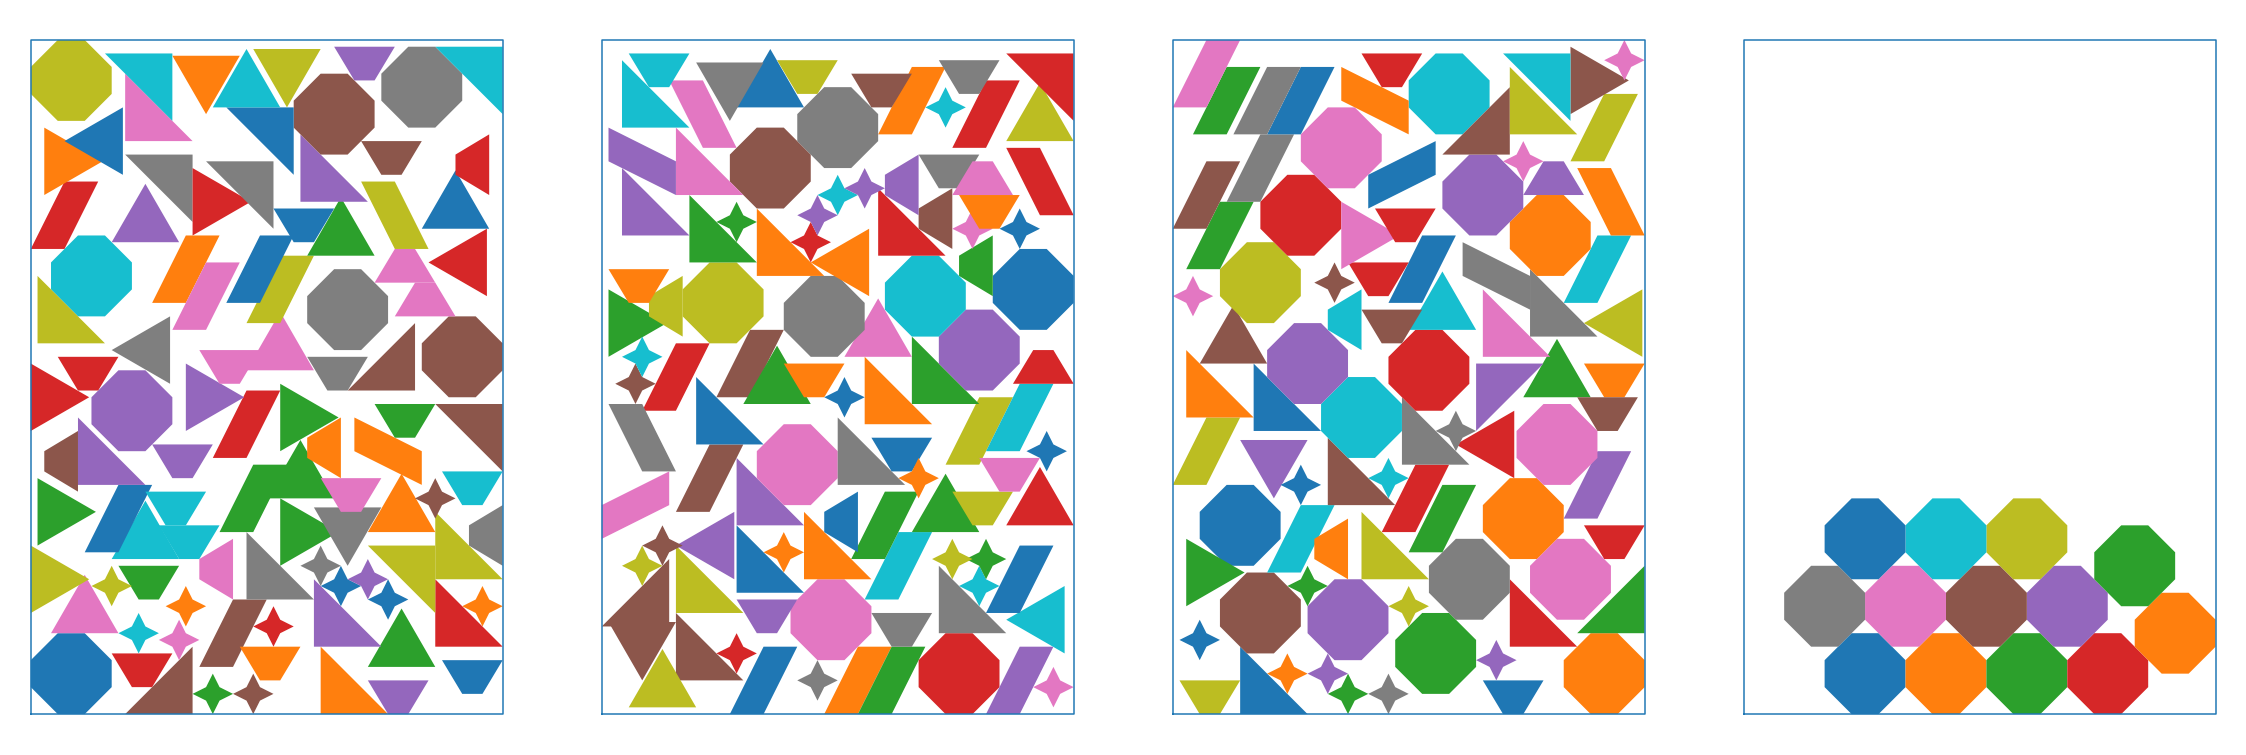

In [147]:
plot_packing(packing, 10)

In [148]:
fit = fitness(packing.bins, packing.bin_size, packing.coeffs)
fit

0.6716767728939337

In [40]:
greedy_decreasingarea_fitness = []
greedy_decreasingarea_time = []
greedy_random_fitness = []
greedy_random_time = []

In [118]:
sa_random_fitness = []
sa_random_time = []

In [91]:
greedy_random_fitness.append(fit)
greedy_random_time.append(time_)

In [144]:
sa_random_fitness.append(fit)
sa_random_time.append(time_)

In [94]:
greedy_random_fitness

[0.7525322172787664,
 0.7275477373354771,
 0.7423443984297091,
 0.7404330930026534]

In [93]:
greedy_random_time

[42.58948588371277, 183.872478723526, 385.16401839256287, 716.7772541046143]

In [95]:
greedy_decreasingarea_fitness

[0.8238603054679786,
 0.7865877612578421,
 0.8322907351915123,
 0.8161926304617162]

In [96]:
greedy_decreasingarea_time

[44.24932289123535, 198.966614484787, 458.8139989376068, 762.3843388557434]

In [145]:
sa_random_fitness

[0.6328015052777287,
 0.6446836091483306,
 0.6358967029028719,
 0.6528800269782508,
 0.6363346237723846]

In [149]:
sa_random_time

[0.2622976303100586,
 43.37841176986694,
 82.54798579216003,
 189.56543612480164,
 184.642737865448]

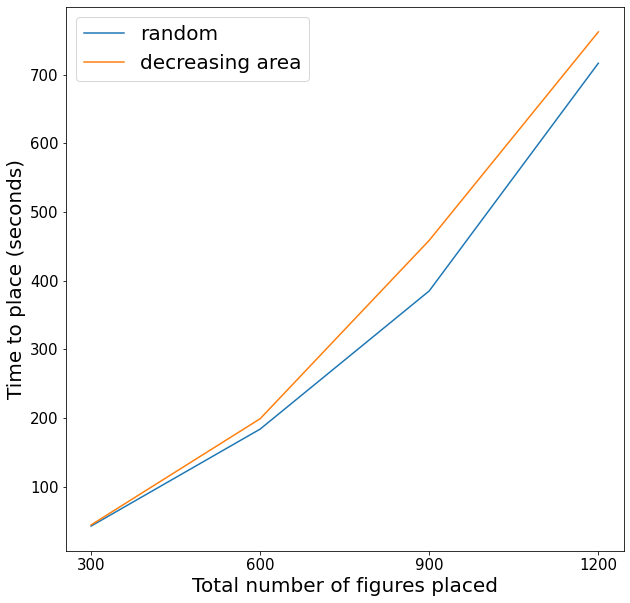

In [170]:
plt.figure(figsize=(10,10))
plt.xlabel('Total number of figures placed', fontsize=20)
plt.xticks([300, 600, 900, 1200], fontsize=15)
plt.ylabel('Time to place (seconds)', fontsize=20)
plt.yticks([100, 200, 300, 400, 500, 600, 700, 800], fontsize=15)
plt.plot([300, 600, 900, 1200], greedy_random_time, label='random')
plt.plot([300, 600, 900, 1200], greedy_decreasingarea_time, label='decreasing area')
plt.legend(fontsize=20)

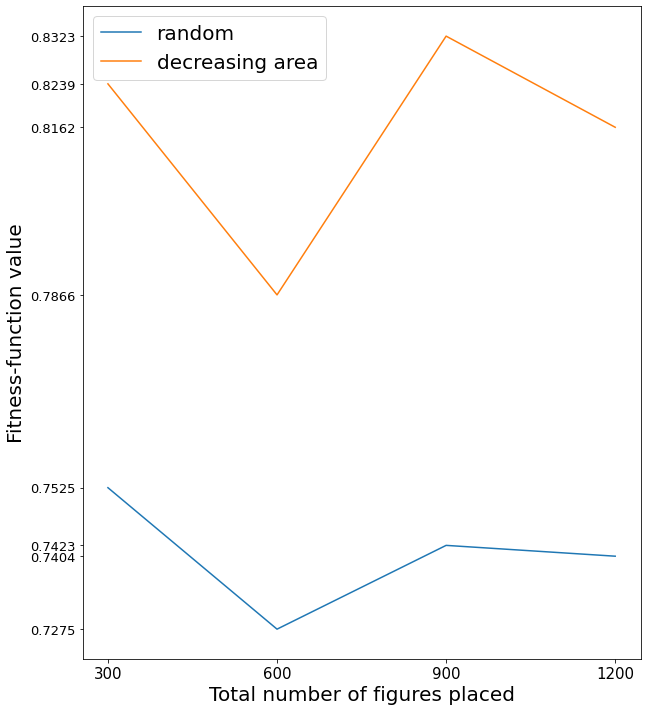

In [173]:
plt.figure(figsize=(10,12))
plt.xlabel('Total number of figures placed', fontsize=20)
plt.xticks([300, 600, 900, 1200], fontsize=15)
plt.ylabel('Fitness-function value', fontsize=20)
plt.yticks(greedy_random_fitness + greedy_decreasingarea_fitness, fontsize=13)
plt.plot([300, 600, 900, 1200], greedy_random_fitness, label='random')
plt.plot([300, 600, 900, 1200], greedy_decreasingarea_fitness, label='decreasing area')
plt.legend(fontsize=20)

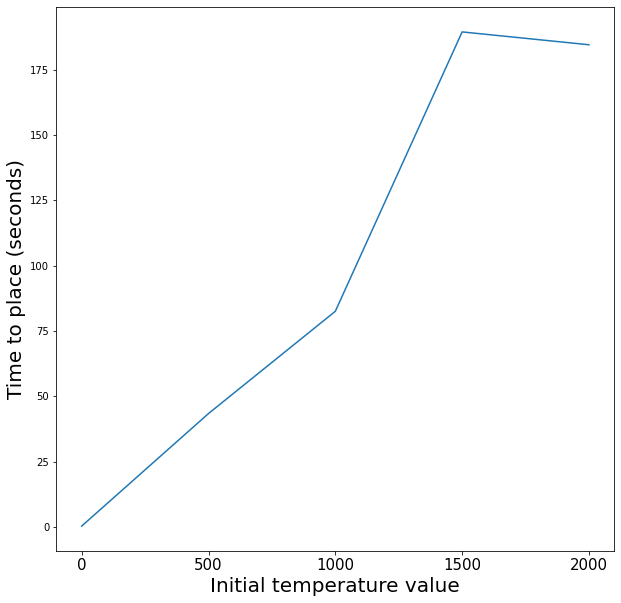

In [177]:
plt.figure(figsize=(10,10))
plt.xlabel('Initial temperature value', fontsize=20)
plt.xticks([0, 500, 1000, 1500, 2000], fontsize=15)
plt.ylabel('Time to place (seconds)', fontsize=20)
plt.plot([0, 500, 1000, 1500, 2000], sa_random_time)

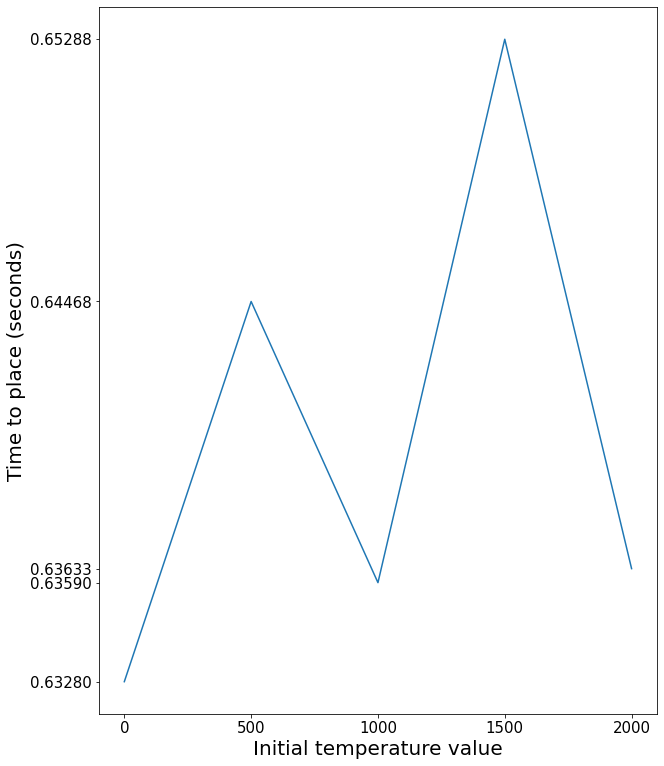

In [182]:
plt.figure(figsize=(10,13))
plt.xlabel('Initial temperature value', fontsize=20)
plt.xticks([0, 500, 1000, 1500, 2000], fontsize=15)
plt.yticks(sa_random_fitness, fontsize=15)
plt.ylabel('Time to place (seconds)', fontsize=20)
plt.plot([0, 500, 1000, 1500, 2000], sa_random_fitness)